In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import os
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import json
import pandas as pd

from ml_genn import Network, Population, Connection
from ml_genn.callbacks import SpikeRecorder, VarRecorder
from ml_genn.compilers import InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput
from ml_genn.synapses import Exponential

from ml_genn.utils.data import calc_latest_spike_time
from ml_genn.compilers.event_prop_compiler import default_params

from ml_genn.utils.data import (calc_latest_spike_time, calc_max_spikes,
                                preprocess_tonic_spikes)

from rawHD_dataset_loader_padded_spikes import rawHD_Loader

In [3]:
# sample ID used for visual
sample_id = 0

In [4]:
cwd_dir = os.getcwd()
output_dir = os.path.expanduser(cwd_dir) + "/output/rawHD_test_run_11_cross_validation/"
param_dir = "params.json"

with open((output_dir + param_dir), "r") as f:
        params = json.load(f)
        
training_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "training_details.csv")
testing_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "testing_details.csv")

In [5]:
x_train, y_train, x_test, y_test, x_validation, y_validation = rawHD_Loader(dir = os.getcwd() + "/raw-spiking-heidleberg-digits-80input/",
                                                                           num_samples=params["num_samples"],
                                                                           shuffle = True,
                                                                           shuffle_seed = 0,
                                                                           process_padded_spikes = False)

In [6]:
# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

#x_test = np.load("spiking-google-speech-commands/testing_x_spikes.npy", allow_pickle=True)
#y_test = np.load("spiking-google-speech-commands/testing_y_spikes.npy", allow_pickle=True)

# Preprocess
x_test_spikes = []
for i in range(len(x_test)):
    events = x_test[i]
    x_test_spikes.append(preprocess_tonic_spikes(events, 
                                                  x_test[0].dtype.names,
                                                  (params["NUM_INPUT"], 1, 1),
                                                  time_scale = 1))

# Determine max spikes and latest spike time
max_spikes = calc_max_spikes(x_test_spikes)
latest_spike_time = calc_latest_spike_time(x_test_spikes)
print(f"Max spikes {max_spikes}, latest spike time {latest_spike_time}")

Skipping, found downloaded files in "./spiking-google-speech-commands" (use force=True to force download)
Max spikes 2190, latest spike time 1599


In [7]:
# change directory for output code of (ML_)GeNN
try:
    os.makedirs("output/" + params["output_dir"] + "_inference_run")
except:
    pass

os.chdir("output/" + params["output_dir"] + "_inference_run")

In [8]:
accuracy_list = []

for speaker in np.sort(training_details.Speaker.unique()):
    print(f" ! Running Inference for Serialiser {speaker} !")
    
    # loading pretrained weights
    w_i2h = np.load(output_dir + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop0_Pop1-g.npy", allow_pickle = True)
    w_i2h = w_i2h.reshape((params["NUM_INPUT"], 
                        params["NUM_HIDDEN"]))

    if params["recurrent"]:
        w_h2h = np.load(output_dir + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop1-g.npy", allow_pickle = True)
        w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                            params["NUM_HIDDEN"]))

    w_h2o = np.load(output_dir + f"serialiser_{speaker}" + f"/{params['NUM_EPOCH'] - 1}-Conn_Pop1_Pop2-g.npy", allow_pickle = True)
    w_h2o = w_h2o.reshape((params["NUM_HIDDEN"], 
                        params["NUM_OUTPUT"]))
    
    network = Network(default_params)

    with network:
        # Populations
        input = Population(SpikeInput(max_spikes = params["BATCH_SIZE"] * max_spikes),
                        params["NUM_INPUT"],
                        record_spikes=True)
        
        hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                        tau_mem=20.0),
                    params.get("NUM_HIDDEN"), 
                    record_spikes=True)
        
        output = Population(LeakyIntegrate(tau_mem=20.0, 
                                    readout="avg_var_exp_weight"),
                    params.get("NUM_OUTPUT"), 
                    record_spikes=True)

        Connection(input, hidden, Dense(weight = w_i2h),
                    Exponential(5.0))
        
        if params.get("recurrent"):
            Connection(hidden, hidden, Dense(weight = w_h2h),
                    Exponential(5.0))
        
        Connection(hidden, output, Dense(w_h2o),
                    Exponential(5.0))

    compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                                reset_in_syn_between_batches=True,
                                #quantise_num_weight_bits=8,
                                #quantise_weight_percentile=99,
                                batch_size = params.get("BATCH_SIZE"))

    compiled_net = compiler.compile(network)


    with compiled_net:

        callbacks = ["batch_progress_bar",
                    SpikeRecorder(input, 
                                key = "input_spikes",
                                example_filter = sample_id),
                    SpikeRecorder(hidden,
                                key = "hidden_spikes",
                                example_filter = sample_id),
                    VarRecorder(hidden, 
                                var = "v",
                                key = "hidden_voltages",
                                example_filter = sample_id),
                    VarRecorder(output, 
                                var = "v",
                                key = "output_voltages",
                                example_filter = sample_id)]
        
        
        metrics, cb_data = compiled_net.evaluate({input: x_test_spikes}, {output: y_test}, callbacks = callbacks)
        
        #metrics, cb_data = compiled_net.predict({input: x_test_spikes}, output, callbacks = callbacks)

        #compiled_net.save(("quant8",), serialiser)


        print(f"Accuracy = {100 * metrics[output].result}%")
        
        accuracy_list.append(100 * metrics[output].result)

 ! Running Inference for Serialiser 0 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


/its/home/ts468/PhD/ve/genn_5_0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 74.75it/s, SparseCategoricalAccuracy: 0.8467]


Accuracy = 84.6731448763251%
 ! Running Inference for Serialiser 1 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 74.42it/s, SparseCategoricalAccuracy: 0.8578]


Accuracy = 85.7773851590106%
 ! Running Inference for Serialiser 2 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 75.47it/s, SparseCategoricalAccuracy: 0.8905]


Accuracy = 89.04593639575971%
 ! Running Inference for Serialiser 3 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 75.08it/s, SparseCategoricalAccuracy: 0.8224]


Accuracy = 82.24381625441696%
 ! Running Inference for Serialiser 6 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 75.07it/s, SparseCategoricalAccuracy: 0.9002]


Accuracy = 90.01766784452296%
 ! Running Inference for Serialiser 7 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 75.48it/s, SparseCategoricalAccuracy: 0.8746]


Accuracy = 87.45583038869258%
 ! Running Inference for Serialiser 8 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 74.93it/s, SparseCategoricalAccuracy: 0.8772]


Accuracy = 87.72084805653711%
 ! Running Inference for Serialiser 9 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 75.35it/s, SparseCategoricalAccuracy: 0.8944]


Accuracy = 89.4434628975265%
 ! Running Inference for Serialiser 10 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 75.49it/s, SparseCategoricalAccuracy: 0.8489]


Accuracy = 84.89399293286219%
 ! Running Inference for Serialiser 11 !
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_test_run_11_cross_validation_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 74.88it/s, SparseCategoricalAccuracy: 0.8370]

Accuracy = 83.70141342756183%


In [9]:
# use to print predicted and ground truth output of GeNN Inference run
if False:
    os.chdir("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project")

    my_list = []
    for i in range(len(y_test)):
        my_list.append(f"Pred: {np.argmax(metrics[output][i])}, True:{y_test[i]}")

    file_path = "GeNN_floating_point_recurrent.txt"
    print(my_list)

    with open(file_path, 'w') as file:
        # Join the list elements into a single string with a newline character
        data_to_write = '\n'.join(my_list)
        
        # Write the data to the file
        file.write(data_to_write)

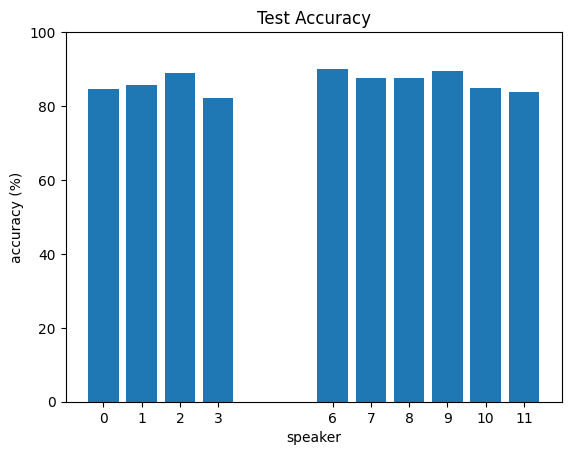

In [11]:
plt.bar(np.sort(training_details.Speaker.unique()), accuracy_list)

plt.ylim(0, 100)
plt.ylabel("accuracy (%)")
plt.xlabel("speaker")
plt.xticks(np.sort(training_details.Speaker.unique()))
plt.title("Test Accuracy")
plt.show()